# Topic 3: Recommender System

## Business Objective/Problem
- Tiki là một hệ sinh thái thương mại “all in one”, trong
đó có tiki.vn, là một website thương mại điện tử đứng
top 2 của Việt Nam, top 6 khu vực Đông Nam Á.
- Trên trang này đã triển khai nhiều tiện ích hỗ trợ nâng
cao trải nghiệm người dùng và họ muốn xây dựng
nhiều tiện ích hơn nữa.
- Giả sử công ty này chưa triển khai Recommender
System và bạn được yêu cầu triển khai hệ thống này,
bạn sẽ làm gì?
Đ

## Các kiến thức/ kỹ năng cần để giải quyết
vấn đề này:
- Hiểu vấn đề
- Import các thư viện cần thiết và hiểu cách sử dụng
- Đọc dữ liệu (dữ liệu project này được cung cấp)
- Thực hiện EDA cơ bản (sử dụng Pandas Profiling
Report)
- Tiền xử lý dữ liệu: làm sạch, tạo tính năng mới, lựa
chọn tính năng cần thiết…

## Bước 1: Business Understanding
- Dựa vào yêu cầu nói trên => xác định vấn đề:
  - Chưa có hệ thống Recommendation System
  - => Mục tiêu/ vấn đề: Xây dựng Recommendation System
  cho một hoặc một số nhóm hàng hóa trên tiki.vn giúp đề
  xuất và gợi ý cho người dùng/ khách hàng. => Xây dựng
  các mô hình đề xuất:
    - Content-based filtering
    - Collaborative filtering

# Bước 2: Data Understanding/ Acquire
- Từ mục tiêu/ vấn đề đã xác định: xem xét các dữ
liệu cần thiết:
  - Dữ liệu được cung cấp sẵn gồm có các tập tin:
  ProductRaw.csv, ReviewRaw.csv chứa thông tin sản phẩm,
  review và rating cho các sản phẩm thuộc các nhóm hàng
  hóa như Mobile_Tablet, TV_Audio, Laptop, Camera,
  Accessory

# Bước 3: Data preparation/ Prepare

### 3. Content base Filtering - Cosine Similarity

- Content-based recommendation system based on the same attributes of the product snar to give suggestions to the user

In [1]:
! pip install jieba
! pip install underthesea

     |████████████████████████████████| 7.5 MB 26.4 MB/s 
     |████████████████████████████████| 235 kB 41.6 MB/s 
     |████████████████████████████████| 3.1 MB 72.2 MB/s 
     |████████████████████████████████| 743 kB 69.3 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 3.3 MB 44.3 MB/s 
     |████████████████████████████████| 61 kB 575 kB/s 
     |████████████████████████████████| 895 kB 80.7 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=4d9170c178153d6bcb6cd6b9360eeb4cff524fea90ff4ba8ff012b448754d64b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS0_K271_PhamThiHoa/Project_3'

/content/gdrive/My Drive/LDS0_K271_PhamThiHoa/Project_3


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
from gensim import corpora, models, similarities
import jieba
import re
import string
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Read data:
products = pd.read_csv('Data/Products.csv')
reviews = pd.read_csv('Data/Reviews.csv',lineterminator='\n')

In [6]:
products.shape

(4373, 10)

In [7]:
products.head(3)

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4373 entries, 0 to 4372
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      4373 non-null   int64  
 1   name         4373 non-null   object 
 2   description  4370 non-null   object 
 3   rating       4373 non-null   float64
 4   price        4373 non-null   int64  
 5   list_price   4373 non-null   int64  
 6   brand        4373 non-null   object 
 7   group        4373 non-null   object 
 8   url          4373 non-null   object 
 9   image        4373 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 341.8+ KB


- We will use columns: 'name' and 'description' to buil model for this topic
- Column name have no Null, column decription has 3 null

In [9]:
# Creat column 'name_descrption' by concatenating column name and description
products['name_description'] = products['name'] + ' ' +  products['description']
products[['name_description']].head()

,name_description
0,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...
1,Tai nghe bluetooth không dây F9 True wireless ...
2,Chuột Không Dây Logitech M331 Silent - Hàng Ch...
3,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...
4,Tai Nghe Bluetooth Apple AirPods Pro True Wire...


In [10]:
# Check null
products[products['name_description'].isnull()]

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_description
1424,75831435,Camera Ip EZVIZ C8C hồng ngoại không dây Full ...,NaN,0.0,1465000,3200000,EZVIZ,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-ip-ezviz-c8c-hong-ngoai-khong-d...,https://salt.tikicdn.com/cache/280x280/ts/prod...,NaN
2504,11607917,Màn Hình LED LG 27MK600M-B 27 inch Full HD (19...,NaN,0.0,4200000,5500000,LG,Laptop - Máy Vi Tính - Linh kiện/Thiết Bị Văn ...,https://man-hinh-led-lg-27mk600m-b-27-inch-ful...,https://salt.tikicdn.com/cache/280x280/ts/prod...,NaN
3263,16608046,Điện Thoại Di Động Forme A5 - Hãng phân phối c...,NaN,3.7,335000,389000,Forme,Điện Thoại - Máy Tính Bảng/Điện thoại phổ thông,https://dien-thoai-di-dong-forme-a5-hang-phan-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,NaN


In [11]:
# Delete rows have null data
products = products[~products['name_description'].isnull()]
# Reset index
products = products.reset_index()

In [12]:
products.shape

(4370, 12)

In [13]:
# Get 5 name_description
for i in range(5):
  print(products.iat[i,11])
  print('-'*20)


Tai nghe Bluetooth Inpods 12 - Cảm biến vân tay, chống nước,màu sắc đa dạng- 5 màu sắc lựa chọn THÔNG TIN CHI TIẾT
Dung lượng pin 300
Thời gian pin - Thời gian nghe nhạc liên tục từ 2.5-4h - Thời gian sạc đầy chỉ khoảng 60p - Thời gian chờ lên tới 140 giờ
Bluetooth 5
Thương hiệu OEM
Xuất xứ thương hiệu Trung Quốc
Độ nhạy cảm biến vân tay
Model i12
Loại Jack cắm USB Cable
Trọng lượng 300g
Thời gian sử dụng
- Thời gian nghe nhạc liên tục từ 2.5-4h
SKU 4096608751631
MÔ TẢ SẢN PHẨM
INPOD 12 là phiên bản nâng cấp mới nhất , tai nghe Bluetooth 5.0 có thiết kế tỉ lệ chuẩn 1:1 với tai Airpod chính hãng
Lược bỏ nút bấm trên thân tai thay vào đó là nút cảm ứng sử dụng dễ dàng và thuận tiện hơn
Thao tác nhận cuộc gọi đến, chuyển nhạc...một cách dễ dàng chỉ bằng 1 chạm
Bluetooth 5.0 mới nhất cho kết nối vô cùng ổn định
- Bluetooth 5.0 mới nhất cho kết nối vô cùng ổn định
- 2 tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc
- Chất âm và thời lượng pin được cải thiện tối ưu
- Dock sạc tiện l

In [14]:
# Load Stopwords
STOP_WORD_FILE = 'Data/vietnamese-stopwords.txt'
with open(STOP_WORD_FILE,'r', encoding='utf-8') as file:
  stop_words = file.read()

stop_words = stop_words.split('\n')
stop_words

['a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy',
 'ba',
 'ba_ba',
 'ba_bản',
 'ba_cùng',
 'ba_họ',
 'ba_ngày',
 'ba_ngôi',
 'ba_tăng',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu',
 'bao_nả',
 'bay_biến',
 'biết',
 'biết_bao',
 'biết_bao_nhiêu',
 'biết_chắc',
 'biết_chừng_nào',
 'biết_mình',
 'biết_mấy',
 'biết_thế',
 'biết_trước',
 'biết_việc',
 'biết_đâu',
 'biết_đâu_chừng',
 'biết_đâu_đấy',
 'biết_được',
 'buổi',
 'buổi_làm',
 'buổi_mới',
 'buổi_ngày',
 'buổi_sớm',
 'bà',
 'bà_ấy',
 'bài',
 'bài_bác',
 'bài_bỏ',
 'bài_cái',
 'bác',
 'bán',
 'bán_cấp',
 'bán_dạ',
 'bán_thế',
 'bây_bẩy',
 'bây_chừ',
 'bây_giờ',
 'bây_nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên_bị',
 'bên_có',
 'bên_cạnh',
 'bông',
 'bước',
 'bước_khỏi',
 'bước_tới',
 'bước_đi',
 'bạn',
 'bản',
 'bản_bộ',
 'bản_riêng',
 'bản_thân',
 'bản_ý',
 'bất_chợt',
 'bất_cứ',
 'bất_giác',
 'bất_kì',
 'bất_kể',
 'bất_kỳ',
 'bất_luận',
 'bất_ngờ',
 'bất_nhược',
 'bất_quá',
 'bất_quá_chỉ',
 'bất_thình_l

In [15]:
# lower
products['name_description'] = products['name_description'].str.lower()
# Remove annunciation
qc = 'giá sản phẩm trên tiki đã bao gồm thuế theo luật hiện hành. tuy nhiên tuỳ vào từng loại sản phẩm hoặc phương thức, địa chỉ giao hàng mà có thể phát sinh thêm chi phí khác như phí vận chuyển, phụ phí hàng cồng kềnh, ...'
products['name_description'] = products['name_description'].str.replace(qc,'')
# Remove some descriptive words
n1 = 'thông tin chi tiết'
n2 = 'mô tả sản phẩm'
n3 = 'tình trạng'
n4 = 'thông số'
n5 = 'hướng dẫn sử dụng'
n6 = 'thương hiệu'
n7 = 'xuất xứ'
for i in [n1,n2,n3,n4,n5,n6,n7]:
  products['name_description'] = products['name_description'].str.replace(i,'')


In [16]:
# Remove Number
products['name_description'] = products['name_description'].str.replace('\d+',' ')
# Remove '\n', '\t' and special character
lst =  ['—','|','\…','•', ',', '.', '\...', '\-', ';', '\?', '\%', '(', ')', '\+', '\/','\"',', ',"\'",'\[','\]','\:','\-','\\n','\\t','\. ','\%','£','$','\"','&','≥','._','±','\*','\//','“','”','._a','v-','v-_a','\–','\\x08','  ','  ','  ','  ']
for i in lst:
  products['name_description'] = products['name_description'].str.replace(i,' ')
# Remove singal character
products['name_description'] = products['name_description'].apply(lambda a: re.sub('\s[a-zA-Z]{1}\s', ' ',a))

In [17]:
# Get 5 name_description to check
for i in range(5):
  print(products.iat[i,11])
  print('-'*20)

tai nghe bluetooth inpods cảm biến vân tay chống nước màu sắc đa dạng màu sắc lựa chọn dung lượng pin thời gian pin thời gian nghe nhạc liên tục từ thời gian sạc đầy chỉ khoảng thời gian chờ lên tới giờ bluetooth oem trung quốc độ nhạy cảm biến vân tay model loại jack cắm usb cable trọng lượng thời gian sử dụng thời gian nghe nhạc liên tục từ sku inpod là phiên bản nâng cấp mới nhất tai nghe bluetooth có thiết kế tỉ lệ chuẩn với tai airpod chính hãng lược bỏ nút bấm trên thân tai thay vào đó là nút cảm ứng sử dụng dễ dàng và thuận tiện hơn thao tác nhận cuộc gọi đến chuyển nhạc một cách dễ dàng chỉ bằng chạm bluetooth mới nhất cho kết nối vô cùng ổn định bluetooth mới nhất cho kết nối vô cùng ổn định tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc chất âm và thời lượng pin được cải thiện tối ưu dock sạc tiện lợi cho tới lần sạc đầy pin tai nghe các thiết bị tương thích các thiết bị bluetooth như cho xiaomi samsung apple huawei oppo vivo lenovo tablet v thời gian nghe nhạc liên

In [18]:
products[products.isnull()].count()

index               0
item_id             0
name                0
description         0
rating              0
price               0
list_price          0
brand               0
group               0
url                 0
image               0
name_description    0
dtype: int64

In [19]:
products['name_description_pre'] = products['name_description'].apply(lambda x: word_tokenize(x, format= 'text'))
products['name_description_pre'].head()

0    tai nghe bluetooth inpods cảm_biến vân tay chố...
1    tai nghe bluetooth không dây true wireless doc...
2    chuột không dây logitech silent hàng chính hãn...
3    loa bluetooth kiêm đồng_hồ báo_thức trong robo...
4    tai nghe bluetooth apple airpods pro true wire...
Name: name_description_pre, dtype: object

In [20]:
type(products)

pandas.core.frame.DataFrame

In [21]:
products.shape

(4370, 13)

In [22]:
products.head()

,index,item_id,name,description,rating,price,list_price,brand,group,url,image,name_description,name_description_pre
0,0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,tai nghe bluetooth inpods cảm biến vân tay chố...,tai nghe bluetooth inpods cảm_biến vân tay chố...
1,1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,tai nghe bluetooth không dây true wireless doc...,tai nghe bluetooth không dây true wireless doc...
2,2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,chuột không dây logitech silent hàng chính hãn...,chuột không dây logitech silent hàng chính hãn...
3,3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,loa bluetooth kiêm đồng hồ báo thức trong robo...,loa bluetooth kiêm đồng_hồ báo_thức trong robo...
4,4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,tai nghe bluetooth apple airpods pro true wire...,tai nghe bluetooth apple airpods pro true wire...


In [23]:
products = products.reset_index()

In [24]:
# TFIDF
tf = TfidfVectorizer(analyzer= 'word', min_df = 0, stop_words = stop_words)

In [25]:
tfidf_matrix = tf.fit_transform(products['name_description_pre'])

# Cosine Similarity

In [26]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [27]:
cosine_similarities

array([[1.        , 0.49140255, 0.08432566, ..., 0.00978787, 0.0045873 ,
        0.05396183],
       [0.49140255, 1.        , 0.08385463, ..., 0.0154867 , 0.02915621,
        0.08711382],
       [0.08432566, 0.08385463, 1.        , ..., 0.03104991, 0.01818186,
        0.06767225],
       ...,
       [0.00978787, 0.0154867 , 0.03104991, ..., 1.        , 0.00423783,
        0.02635412],
       [0.0045873 , 0.02915621, 0.01818186, ..., 0.00423783, 1.        ,
        0.04082177],
       [0.05396183, 0.08711382, 0.06767225, ..., 0.02635412, 0.04082177,
        1.        ]])

In [28]:
cosine_similarities.shape

(4370, 4370)

In [29]:
# Get 10 recomen for each product
results = {}
for idx, row in products.iterrows():
  similar_indices = cosine_similarities[idx].argsort()[:-10:-1]
  similar_items = [(cosine_similarities[idx][i], products['item_id'][i]) for i in similar_indices]
  results[row['item_id']] = similar_items[1:]

In [30]:
# Get product info:
def item(id):
  return products.loc[products['item_id'] == id]['name'].to_list()[0].split('-')[0]

# Product info recomendation
def recomend(item_id, num):
  print(f'Recomend {num} products for {item(item_id)}:')
  print('-'*50)
  recs = results[item_id][:num]
  a = 1
  for rec in recs:
    print(f"Recomended {num} products: ")
    print(f'{a}. {rec[1]}')
    print(f'Product id: {str(rec[1])} - Name: {item(rec[1])} (score: {str(rec[0])})') 
    a+=1
    print()


In [31]:
item_id = 1059892
recomend(item_id,5)

Recomend 5 products for Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine II 0.9m :
--------------------------------------------------
Recomended 5 products: 
1. 1060082
Product id: 1060082 - Name: Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine II 1.8m  (score: 0.9704416206018397)

Recomended 5 products: 
2. 3220143
Product id: 3220143 - Name: Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine+ 0.9m (Không Kèm Bao Da)  (score: 0.6727871224001608)

Recomended 5 products: 
3. 15682170
Product id: 15682170 - Name: Dây Cáp Sạc USB (score: 0.5498354825838487)

Recomended 5 products: 
4. 49661643
Product id: 49661643 - Name: Dây Cáp Sạc USB Type (score: 0.5178299243610145)

Recomended 5 products: 
5. 234886
Product id: 234886 - Name: Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine+ 1.8m (Không Kèm Bao Da)  (score: 0.5094942166934299)



In [32]:
item_id = 48102821
recomend(item_id,5)

Recomend 5 products for Tai nghe Bluetooth Inpods 12 :
--------------------------------------------------
Recomended 5 products: 
1. 56365197
Product id: 56365197 - Name: Tai nghe bluetooth không dây i12 TWS 5.0, thiết kế nhỏ gọn, chất lượng âm thanh nổi HIFI, chức năng giảm tạp âm (score: 0.508126331456319)

Recomended 5 products: 
2. 22413470
Product id: 22413470 - Name: Tai Nghe Bluetooth Air.podes Cảm Ứng Công Nghệ Cao 5.0 (score: 0.5042862960811241)

Recomended 5 products: 
3. 52333193
Product id: 52333193 - Name: Tai nghe bluetooth không dây F9 True wireless Dock Sạc có Led Báo Pin Kép (score: 0.49140254679786854)

Recomended 5 products: 
4. 56885678
Product id: 56885678 - Name: Tai Nghe Bluetooth TWS F9 Tai Nghe Nhét  Hai Tai  Bluetooth 5.0  True wireless   Cảm Ứng Vân Tay, Nút Bấm Chống Nước Dock Sạc Dự Phòng   + Túi đựng tai nghe  (score: 0.48855021730514714)

Recomended 5 products: 
5. 26348659
Product id: 26348659 - Name: Tai Nghe Bluetooth True Wireless AMOI F9 5.0 Cảm Ứng 

In [33]:
item_id = 299461
recomend(item_id,5)

Recomend 5 products for Chuột Không Dây Logitech M331 Silent :
--------------------------------------------------
Recomended 5 products: 
1. 299431
Product id: 299431 - Name: Chuột Không Dây Logitech M221  (score: 0.911025501577981)

Recomended 5 products: 
2. 389145
Product id: 389145 - Name: Chuột Không Dây Logitech B175  (score: 0.6610045976551857)

Recomended 5 products: 
3. 203734
Product id: 203734 - Name: Chuột Không Dây Logitech M325  (score: 0.6046731982459184)

Recomended 5 products: 
4. 54665
Product id: 54665 - Name: Chuột Không Dây Logitech M185  (score: 0.5994685541745849)

Recomended 5 products: 
5. 899588
Product id: 899588 - Name: Chuột Không Dây DareU LM115G  (score: 0.5313243539687856)



In [34]:
item_id = 60228865
recomend(item_id,5)

Recomend 5 products for Micro Đôi Karaoke :
--------------------------------------------------
Recomended 5 products: 
1. 56540134
Product id: 56540134 - Name: Bộ 2 Micro Karaoke Không Dây Model MV01 Siêu Hay  (score: 0.6894405826468895)

Recomended 5 products: 
2. 57865557
Product id: 57865557 - Name: Micro Không Dây Karaoke Vietstar, 2 Mic Chuyên Dành Cho Mọi Loa Kéo, Âm Ly, Tần Số 50. Model MV01, Hàng Nhập Khẩu (score: 0.6270480684915557)

Recomended 5 products: 
3. 46654004
Product id: 46654004 - Name:  Micro Có Dây karaoke Shubole K (score: 0.6196519300023361)

Recomended 5 products: 
4. 68621140
Product id: 68621140 - Name: Bộ 2 Micro Không Dây Karaoke Cực Hay MU02 Màu Xám, Kết Nối Với Loa Kéo, Amply Bằng Cổng MIC 6. Chính Hãng (score: 0.4927987297522233)

Recomended 5 products: 
5. 48490928
Product id: 48490928 - Name: Loa kẹo kéo karaoke mini k58 kèm 1 micro không dây (score: 0.45005924465938313)



# Word Cloud

In [35]:
from wordcloud import WordCloud

In [36]:
def get_product_text(item_id, num):
  id_rec = [r[1] for r in results[item_id]] + [item_id]
  text = (products[products.item_id.isin(id_rec)])
  return ' '.join(text.name + text.description)

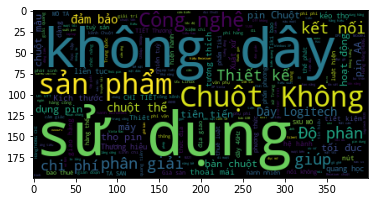

In [37]:
item_id = 299461
wc_text = get_product_text(item_id,5)
wc = WordCloud(stopwords=stop_words).generate(wc_text)
plt.imshow(wc)

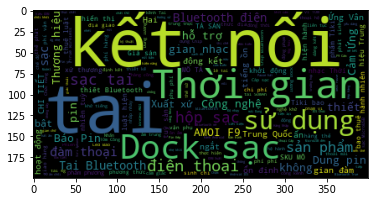

In [38]:
item_id = 48102821
wc_text = get_product_text(item_id,5)
wc = WordCloud(stopwords=stop_words).generate(wc_text)
plt.imshow(wc)

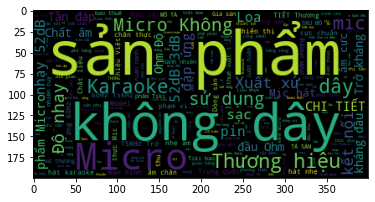

In [39]:
item_id = 60228865
wc_text = get_product_text(item_id,5)
wc = WordCloud(stopwords=stop_words).generate(wc_text)
plt.imshow(wc)

# Save Resullts

In [40]:
info = []
for p_id, v in results.items():
  for item in v:
    info.append({
        'product id:': p_id,
        'id_rec': item[1],
        'score': item[0]
    })
  content_based_df = pd.DataFrame(info)

In [41]:
content_based_df.head()

,product id:,id_rec,score
0,48102821,56365197,0.508126
1,48102821,22413470,0.504286
2,48102821,52333193,0.491403
3,48102821,56885678,0.488550
4,48102821,26348659,0.482935


In [42]:
content_based_df.to_csv('Results/CB_Cosine_Similarity.csv')